In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


In [2]:
# Load the dataset (Imagenette, a subset of ImageNet)
train_ds, val_ds = tfds.load('imagenette/320px', 
                        split=['train', 'validation'], 
                        as_supervised=True,
                        with_info=False)
# Function to preprocess the data with augmentation
def preprocess(image, label):
    # Resize the image
    image = tf.image.resize(image, (224, 224))
    
    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Normalize pixel values
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, label


In [3]:

# Prepare the datasets
batch_size = 32
train_ds = train_ds.map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Get dataset info
ds_info = tfds.load('imagenette/320px', with_info=True)[1]
num_classes = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names

# Check dataset shapes
print(f"Training data shape: {ds_info.splits['train'].num_examples} examples")
print(f"Validation data shape: {ds_info.splits['validation'].num_examples} examples")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Training data shape: 12894 examples
Validation data shape: 500 examples
Number of classes: 10
Class names: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


In [4]:

# Create a CNN model
model = models.Sequential([
    # First Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    
    # Second Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Third Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the output and add Dense layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


In [5]:

# Compile the model
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [6]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [7]:

# Train the model
history = model.fit(train_ds, epochs=15, validation_data=val_ds, callbacks=[early_stopping, reduce_lr], verbose=1)


Epoch 1/15
403/403 [==============================] - 28s 59ms/step - loss: 2.1513 - accuracy: 0.2225 - val_loss: 1.8331 - val_accuracy: 0.3560 - lr: 0.0010
Epoch 2/15
403/403 [==============================] - 25s 58ms/step - loss: 1.8143 - accuracy: 0.3688 - val_loss: 1.5038 - val_accuracy: 0.4880 - lr: 0.0010
Epoch 3/15
403/403 [==============================] - 25s 58ms/step - loss: 1.6049 - accuracy: 0.4501 - val_loss: 1.3921 - val_accuracy: 0.5320 - lr: 0.0010
Epoch 4/15
403/403 [==============================] - 26s 60ms/step - loss: 1.4850 - accuracy: 0.4935 - val_loss: 1.2454 - val_accuracy: 0.6080 - lr: 0.0010
Epoch 5/15
403/403 [==============================] - 22s 50ms/step - loss: 1.4008 - accuracy: 0.5323 - val_loss: 1.2833 - val_accuracy: 0.5820 - lr: 0.0010
Epoch 6/15
403/403 [==============================] - 25s 59ms/step - loss: 1.3357 - accuracy: 0.5459 - val_loss: 1.1277 - val_accuracy: 0.6520 - lr: 0.0010
Epoch 7/15
403/403 [==============================] - 26s 

In [8]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(val_ds)
print(f"Test accuracy: {test_accuracy:.2f}")


16/16 [==============================] - 1s 57ms/step - loss: 0.9815 - accuracy: 0.6800
Test accuracy: 0.68


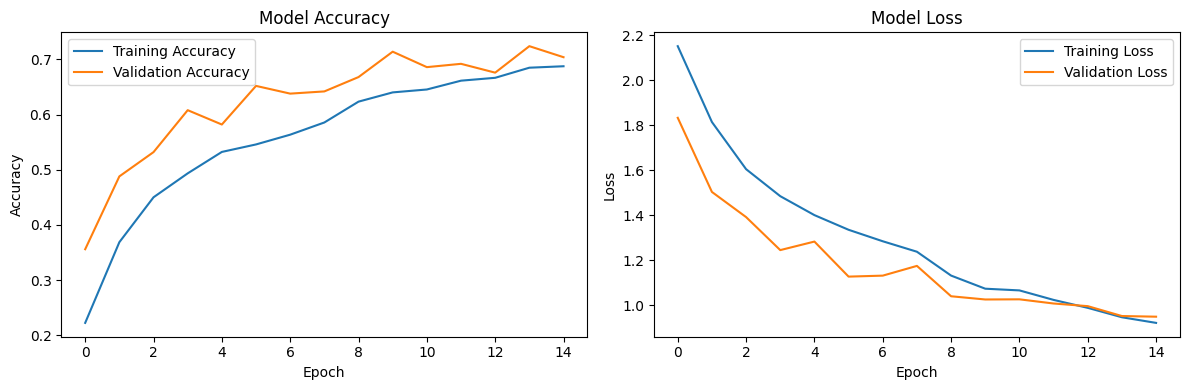

In [9]:

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 228ms/step


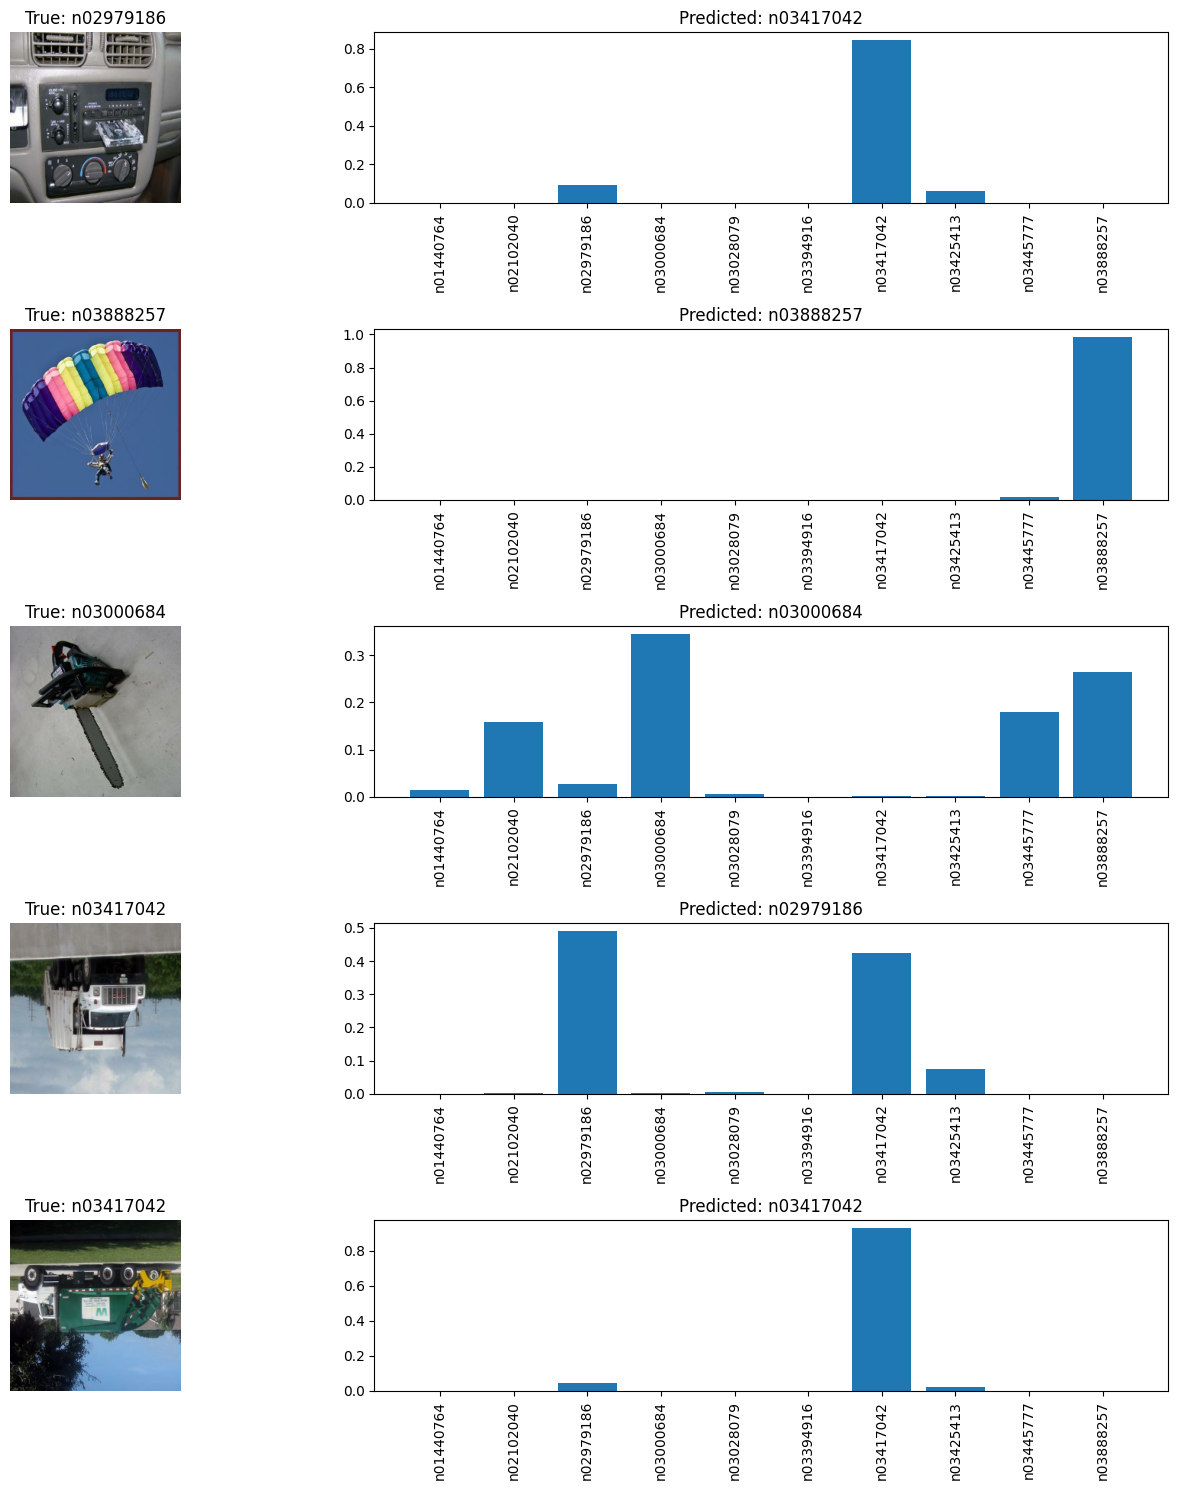

In [10]:

# Make predictions and display results
def predict_and_plot(dataset, num_images=5):
    images, labels = next(iter(dataset.take(1)))
    predictions = model.predict(images[:num_images])
    
    plt.figure(figsize=(15, 3 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 2, 2*i+1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}")
        plt.axis('off')
        
        plt.subplot(num_images, 2, 2*i+2)
        plt.bar(class_names, predictions[i])
        plt.title(f"Predicted: {class_names[np.argmax(predictions[i])]}")
        plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.show()

predict_and_plot(val_ds)


In [11]:

# Save the model
model.save('imagenette_classification_model.h5')